In [1]:
# ウェブインテリジェンス特論最終レポート課題
# 2020.08.06

In [2]:
# 必要なライブラリのインポート
import pandas as pd
import time
import os
import urllib.request, urllib.error
from bs4 import BeautifulSoup
import csv
from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.base import clone
from itertools import combinations
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from matplotlib.colors import ListedColormap

# プロ野球Freak(https://baseball-freak.com/ )というサイトから2009年〜2019年までの個人打撃成績をスクレイピングして収集する

In [3]:
# URLがあるかどうかをチェックする関数
# 以下https://qiita.com/seigot/items/534ca3089d217200a1d6より引用
def checkURL(url):
    try:
        f = urllib.request.urlopen(url)
        print ("OK:" + url )
        return "OK"
        f.close()
    except:
        print ("NotFound:" + url)
        return "NG"

In [4]:
# プロフィールを取得
# 参考：https://note.com/data_science/n/n02f50eae644b

# いらない列を取り除く関数を定義
def remove_row(data):
    data = data.drop("No.", axis=1)
    data = data.drop("生年月日", axis=1)
    data = data.drop("血液型", axis=1)
    data = data.drop("出身地", axis=1)
    return data

# 単位を取り除く関数を定義
def remove_unit(data):
    # 以下https://note.com/data_science/n/n02f50eae644bより引用
    data['年齢'] = data['年齢'].str.replace('歳','')
    data['年俸(推定)'] = data['年俸(推定)'].str.replace('万円','')
    data['年俸(推定)'] = data['年俸(推定)'].str.replace(',','')
    data['身長'] = data['身長'].str.replace('cm','')
    data['年数'] = data['年数'].str.replace('年','')
    data['体重'] = data['体重'].str.replace('kg','')
    # 引用ここまで
    return data

# 西暦とチーム名
years = ['09','10','11','12','13','14','15','16','17','18','19']
teams = ['l','h','e','m','f','bs','g','yb','t','c','d','s']

# 新規フォルダの作成
os.makedirs('data/output_profile')

# 全チームの２００９年〜２０１９年のプロフィールを取得
for team in teams:
    for year in years:
        url = "https://baseball-data.com/"+year+"/player/"+team+"/"
        checkResult = checkURL(url)
        # print(checkResult)
        
        if checkResult=="OK":
            #以下引用
            data = pd.read_html(url)
            data = data[0]
            #print(data)
            #引用ここまで
            dataRemoveRow = remove_row(data)
            dataResult = remove_unit(dataRemoveRow)
            #print(dataResult)
            
            # csvファイルに保存
            dataResult.to_csv('./data/output_profile/output_profile_'+team+'_'+year+'.csv',index=False)
        else:
            print("error")
        
        time.sleep(1)

OK:https://baseball-data.com/09/player/l/
OK:https://baseball-data.com/10/player/l/
OK:https://baseball-data.com/11/player/l/
OK:https://baseball-data.com/12/player/l/
OK:https://baseball-data.com/13/player/l/
OK:https://baseball-data.com/14/player/l/
OK:https://baseball-data.com/15/player/l/
OK:https://baseball-data.com/16/player/l/
OK:https://baseball-data.com/17/player/l/
OK:https://baseball-data.com/18/player/l/
OK:https://baseball-data.com/19/player/l/
OK:https://baseball-data.com/09/player/h/
OK:https://baseball-data.com/10/player/h/
OK:https://baseball-data.com/11/player/h/
OK:https://baseball-data.com/12/player/h/
OK:https://baseball-data.com/13/player/h/
OK:https://baseball-data.com/14/player/h/
OK:https://baseball-data.com/15/player/h/
OK:https://baseball-data.com/16/player/h/
OK:https://baseball-data.com/17/player/h/
OK:https://baseball-data.com/18/player/h/
OK:https://baseball-data.com/19/player/h/
OK:https://baseball-data.com/09/player/e/
OK:https://baseball-data.com/10/pl

In [11]:
# 打撃成績を取得

# いらない列を取り除く関数を定義
def remove_hitting_row(data, number):
    data = data.drop("背番号", axis=1)
    return data

# 西暦とチーム名
years = ['09','10','11','12','13','14','15','16','17','18','19']
teams = ['l','h','e','m','f','bs','g','yb','t','c','d','s']
numbers = ['2','3','4']

# 新規フォルダの作成
os.makedirs('data/output_hitting')

# 全チームの２００９年〜２０１９年の打撃成績を取得
for team in teams:
    for year in years:
        for number in numbers:
            url = "https://baseball-data.com/"+year+"/stats/hitter"+number+"-"+team+"/tpa-1.html"
            checkResult = checkURL(url)
            # print(checkResult)

            if checkResult=="OK":
                data = pd.read_html(url)
                data = data[0]
                #print(data)
                dataResult = remove_hitting_row(data, number)
                #print(dataResult)
                dataResult.to_csv('./data/output_hitting/output_hitting'+number+'_'+team+'_'+year+'.csv',index=False)
            else:
                print("error")

            time.sleep(1)

print("Complete: Scraping")

            
# 余計な行と列を削除
for team in teams:
    for year in years:
        for number in numbers:
            #CSVファイルの読み込み
            data_h = pd.read_csv('./data/output_hitting/output_hitting'+number+'_'+team+'_'+year+'.csv')
            #いらない行を消す
            data_h = data_h.drop(0, axis=0)
            # numberが3,4のときにいらない列を除去
            if number == '3':
                data_h = data_h.drop(["打率","打数","安打","本塁打","打点","出塁率","長打率"], axis=1)
                data_h.head()
            if number == '4':
                data_h = data_h.drop(["打率","打席数","打数","安打","本塁打","打点","盗塁","四死球","三振"], axis=1)
                data_h.head()
            #新たなcsvファイルとして保存
            data_h.to_csv('./data/output_hitting/output_hitting'+number+'_'+team+'_'+year+'.csv',index=False)
print("Complete: Remove")
            
# 打撃成績のcsvファイルをマージする
for team in teams:
    for year in years:
        #CSVファイルの読み込み
        data_h2 = pd.read_csv('./data/output_hitting/output_hitting2_'+team+'_'+year+'.csv')
        data_h3 = pd.read_csv('./data/output_hitting/output_hitting3_'+team+'_'+year+'.csv')
        data_h4 = pd.read_csv('./data/output_hitting/output_hitting4_'+team+'_'+year+'.csv')
        #マージする
        data_h_marge = pd.merge(data_h2, data_h3, on='選手名', how='outer')
        data_h_marge = pd.merge(data_h_marge, data_h4, on='選手名', how='outer')
        #csvファイルとして保存
        data_h_marge.to_csv('./data/output_hitting/output_hitting_'+team+'_'+year+'.csv',index=False)
print("Complete: Marge")

OK:https://baseball-data.com/09/stats/hitter2-l/tpa-1.html
OK:https://baseball-data.com/09/stats/hitter3-l/tpa-1.html
OK:https://baseball-data.com/09/stats/hitter4-l/tpa-1.html
OK:https://baseball-data.com/10/stats/hitter2-l/tpa-1.html
OK:https://baseball-data.com/10/stats/hitter3-l/tpa-1.html
OK:https://baseball-data.com/10/stats/hitter4-l/tpa-1.html
OK:https://baseball-data.com/11/stats/hitter2-l/tpa-1.html
OK:https://baseball-data.com/11/stats/hitter3-l/tpa-1.html
OK:https://baseball-data.com/11/stats/hitter4-l/tpa-1.html
OK:https://baseball-data.com/12/stats/hitter2-l/tpa-1.html
OK:https://baseball-data.com/12/stats/hitter3-l/tpa-1.html
OK:https://baseball-data.com/12/stats/hitter4-l/tpa-1.html
OK:https://baseball-data.com/13/stats/hitter2-l/tpa-1.html
OK:https://baseball-data.com/13/stats/hitter3-l/tpa-1.html
OK:https://baseball-data.com/13/stats/hitter4-l/tpa-1.html
OK:https://baseball-data.com/14/stats/hitter2-l/tpa-1.html
OK:https://baseball-data.com/14/stats/hitter3-l/tpa-1.ht

In [13]:
# プロフィールと打撃成績をマージする

# 西暦とチーム名
years = ['09','10','11','12','13','14','15','16','17','18','19']
teams = ['l','h','e','m','f','bs','g','yb','t','c','d','s']

# 新規フォルダの作成
os.makedirs('data/output_profile_and_hitting')

for team in teams:
    for year in years:
        #CSVファイルの読み込み
        data_p = pd.read_csv('./data/output_profile/output_profile_'+team+'_'+year+'.csv')
        data_h = pd.read_csv('./data/output_hitting/output_hitting_'+team+'_'+year+'.csv')
        
        #マージする
        data_ph_marge = pd.merge(data_p, data_h, on='選手名', how='outer')
        #csvファイルとして保存
        data_ph_marge.to_csv('./data/output_profile_and_hitting/output_profile_and_hitting_'+team+'_'+year+'.csv',index=False)
print("Complete: Marge")

Complete: Marge


# スクレイピングしたデータの整形を行う

In [14]:
# 欠測値をもつサンプルを取り除く
#打撃成績から投手のデータを削除
# 西暦とチーム名
years = ['09','10','11','12','13','14','15','16','17','18','19']
teams = ['l','h','e','m','f','bs','g','yb','t','c','d','s']

for team in teams:
    for year in years:
        #CSVファイルの読み込み
        data_ph = pd.read_csv('./data/output_profile_and_hitting/output_profile_and_hitting_'+team+'_'+year+'.csv')
        
        #プロフィールデータから欠測値のある選手を削除（打撃成績がない＝投手）
        data_ph = data_ph.dropna()
        
        #"-","∞"は0に置き換える
        line_length = len(data_ph)
        row_length = len(data_ph.columns)
        for column in range(row_length):
            for count in range(line_length):
                if data_ph.iat[count, column] == "-":
                    data_ph.iat[count, column] = 0
                if data_ph.iat[count, column] == "∞":
                    data_ph.iat[count, column] = 0
        
        #csvファイルとして保存
        data_ph.to_csv('./data/output_profile_and_hitting/output_remove_profile_and_hitting_'+team+'_'+year+'.csv',index=False)
print("Complete: Remove")

Complete: Remove


In [15]:
# 全チームの打撃データを結合
# 西暦とチーム名
years = ['09','10','11','12','13','14','15','16','17','18','19']
teams = ['l','h','e','m','f','bs','g','yb','t','c','d','s']

data = pd.read_csv('./data/output_profile_and_hitting/output_remove_profile_and_hitting_l_09.csv')

line_length = len(data)
#print(line_length)
for line in range(line_length):
    #print(line)
    #print(data.index[line])
    data = data.drop(data.index[0])
    
#print(data)

    
for team in teams:
    for year in years:
        #CSVファイルの読み込み
        data_ph = pd.read_csv('./data/output_profile_and_hitting/output_remove_profile_and_hitting_'+team+'_'+year+'.csv')
        
        # マージする
        data = pd.concat([data, data_ph])
        
#one-hotエンコーディング
#守備と投打：名義特徴量
data2 = pd.get_dummies(data[["守備","投打"]])
data_encoding = pd.DataFrame(data2)

#プロフィールデータから守備と投打を削除
data = data.drop("守備", axis=1)
data = data.drop("投打", axis=1)

#プロフィールデータとエンコーディングのデータをマージする
data_result = pd.concat([data, data_encoding], axis=1)

#csvファイルとして保存
data_result.to_csv('./data/output_profile_and_hitting/output_profile_and_hitting.csv',index=False)
print("Complete: Marge")

Complete: Marge


In [16]:
# ベストナインのデータを記入
# 今回はベストナインかどうかのデータがなかったので，すべて手打ちで記入
# csvを読み込む
data_ph = pd.read_csv('./data/output_profile_and_hitting/output_profile_and_hitting.csv')

# ベストナインかどうかのクラスラベルを追加
data_ph.insert(1, 'best_nine', 0)

#西武
#2009
data_ph.iloc[3, 1]=1
data_ph.iloc[27, 1] = 1
#2010
data_ph.iloc[33, 1] = 1
#2011
data_ph.iloc[68, 1] = 1
data_ph.iloc[91, 1] = 1
data_ph.iloc[96, 1] = 1
data_ph.iloc[401, 1] = 1
#2012
data_ph.iloc[106, 1] = 1
data_ph.iloc[132, 1] = 1
#2013
data_ph.iloc[152, 1] = 1
#2014
data_ph.iloc[198, 1] = 1
data_ph.iloc[206, 1] = 1
#2015
data_ph.iloc[218, 1] = 1
data_ph.iloc[228, 1] = 1
data_ph.iloc[232, 1] = 1
#2016
data_ph.iloc[252, 1] = 1
#2017
data_ph.iloc[277, 1] = 1
#2018
data_ph.iloc[314, 1] = 1
data_ph.iloc[317, 1] = 1
data_ph.iloc[308, 1] = 1
data_ph.iloc[310, 1] = 1
data_ph.iloc[324, 1] = 1
#2019
data_ph.iloc[343, 1] = 1
data_ph.iloc[346, 1] = 1
data_ph.iloc[357, 1] = 1
data_ph.iloc[340, 1] = 1
data_ph.iloc[354, 1] = 1

#ソフトバンク
#2009
data_ph.iloc[401, 1] = 1
#2010
data_ph.iloc[408, 1] = 1
#2011
data_ph.iloc[450, 1] = 1
data_ph.iloc[444, 1] = 1
data_ph.iloc[461, 1] = 1
data_ph.iloc[449, 1] = 1
#2012
data_ph.iloc[470, 1] = 1
data_ph.iloc[476, 1] = 1
#2013
data_ph.iloc[511, 1] = 1
data_ph.iloc[501, 1] = 1
#2014
data_ph.iloc[532, 1] = 1
data_ph.iloc[549, 1] = 1
#2015
data_ph.iloc[570, 1] = 1
data_ph.iloc[569, 1] = 1
#2017
data_ph.iloc[655, 1] = 1
data_ph.iloc[628, 1] = 1
data_ph.iloc[634, 1] = 1
data_ph.iloc[650, 1] = 1
#2018
data_ph.iloc[664, 1] = 1
data_ph.iloc[669, 1] = 1
#2019
data_ph.iloc[722, 1] = 1

#楽天
#2009
data_ph.iloc[755, 1] = 1
data_ph.iloc[739, 1] = 1
#2010
data_ph.iloc[787, 1] = 1
#2013
data_ph.iloc[891, 1] = 1
data_ph.iloc[879, 1] = 1
data_ph.iloc[876, 1] = 1
#2014
data_ph.iloc[916, 1] = 1
data_ph.iloc[926, 1] = 1
#2017
data_ph.iloc[1027, 1] = 1
data_ph.iloc[1032, 1] = 1
#2019
data_ph.iloc[1082, 1] = 1

#ロッテ
#2010
data_ph.iloc[1153, 1] = 1
data_ph.iloc[1155, 1] = 1
#2012
data_ph.iloc[1236, 1] = 1
#2013
data_ph.iloc[1259, 1] = 1
#2015
data_ph.iloc[1312, 1] = 1
#2016
data_ph.iloc[1361, 1] = 1
data_ph.iloc[1350, 1] = 1
data_ph.iloc[1367, 1] = 1
#2019
data_ph.iloc[1443, 1] = 1

#日ハム
#2009
data_ph.iloc[1477, 1] = 1
data_ph.iloc[1478, 1] = 1
data_ph.iloc[1489, 1] = 1
data_ph.iloc[1495, 1] = 1
#2010
data_ph.iloc[1514, 1] = 1
data_ph.iloc[1512, 1] = 1
#2011
data_ph.iloc[1547, 1] = 1
#2012
data_ph.iloc[1584, 1] = 1
data_ph.iloc[1575, 1] = 1
data_ph.iloc[1579, 1] = 1
#2013
data_ph.iloc[1613, 1] = 1
data_ph.iloc[1629, 1] = 1
#2014
data_ph.iloc[1648, 1] = 1
#2015
data_ph.iloc[1680, 1] = 1
data_ph.iloc[1683, 1] = 1
data_ph.iloc[1686, 1] = 1
#2016
data_ph.iloc[1716, 1] = 1
data_ph.iloc[1717, 1] = 1
data_ph.iloc[1721, 1] = 1
#2017
data_ph.iloc[1749, 1] = 1
#2018
data_ph.iloc[1786, 1] = 1

#オリックス
#2010
data_ph.iloc[1904, 1] = 1
data_ph.iloc[1910, 1] = 1
#2012
data_ph.iloc[1967, 1] = 1
#2014
data_ph.iloc[2034, 1] = 1
data_ph.iloc[2030, 1] = 1
#2016
data_ph.iloc[2101, 1] = 1
#2018
data_ph.iloc[2177, 1] = 1
#2019
data_ph.iloc[2212, 1] = 1

#巨人
#2009
data_ph.iloc[2237, 1] = 1
data_ph.iloc[2232, 1] = 1
data_ph.iloc[2234, 1] = 1
data_ph.iloc[2233, 1] = 1
#2010
data_ph.iloc[2272, 1] = 1
#2011
data_ph.iloc[2306, 1] = 1
data_ph.iloc[2303, 1] = 1
#2012
data_ph.iloc[2338, 1] = 1
data_ph.iloc[2341, 1] = 1
data_ph.iloc[2334, 1] = 1
data_ph.iloc[2335, 1] = 1
#2013
data_ph.iloc[2371, 1] = 1
data_ph.iloc[2375, 1] = 1
data_ph.iloc[2368, 1] = 1
#2014
data_ph.iloc[2407, 1] = 1
#2016
data_ph.iloc[2484, 1] = 1
data_ph.iloc[2475, 1] = 1
#2018
data_ph.iloc[2545, 1] = 1
#2019
data_ph.iloc[2581, 1] = 1
data_ph.iloc[2582, 1] = 1

#横浜
#2009
data_ph.iloc[2612, 1] = 1
#2013
data_ph.iloc[2763, 1] = 1
#2015
data_ph.iloc[2814, 1] = 1
#2016
data_ph.iloc[2847, 1] = 1
#2017
data_ph.iloc[2870, 1] = 1
data_ph.iloc[2890, 1] = 1
data_ph.iloc[2878, 1] = 1
#2018
data_ph.iloc[2923, 1] = 1
data_ph.iloc[2933, 1] = 1
#2019
data_ph.iloc[2966, 1] = 1

#阪神
#2010
data_ph.iloc[3034, 1] = 1
data_ph.iloc[3009, 1] = 1
data_ph.iloc[3005, 1] = 1
data_ph.iloc[3013, 1] = 1
#2011
data_ph.iloc[3043, 1] = 1
data_ph.iloc[3039, 1] = 1
data_ph.iloc[3047, 1] = 1
#2013
data_ph.iloc[3114, 1] = 1
data_ph.iloc[3109, 1] = 1
data_ph.iloc[3116, 1] = 1
#2014
data_ph.iloc[3149, 1] = 1
data_ph.iloc[3145, 1] = 1
data_ph.iloc[3152, 1] = 1
#2015
data_ph.iloc[3181, 1] = 1
data_ph.iloc[3187, 1] = 1

#広島
#2009
data_ph.iloc[3352, 1] = 1
#2011
data_ph.iloc[3429, 1] = 1
#2014
data_ph.iloc[3537, 1] = 1
#2016
data_ph.iloc[3617, 1] = 1
data_ph.iloc[3614, 1] = 1
data_ph.iloc[3629, 1] = 1
data_ph.iloc[3611, 1] = 1
#2017
data_ph.iloc[3649, 1] = 1
data_ph.iloc[3652, 1] = 1
data_ph.iloc[3641, 1] = 1
data_ph.iloc[3662, 1] = 1
data_ph.iloc[3646, 1] = 1
#2018
data_ph.iloc[3683, 1] = 1
data_ph.iloc[3686, 1] = 1
data_ph.iloc[3679, 1] = 1
#2019
data_ph.iloc[3717, 1] = 1
data_ph.iloc[3709, 1] = 1

#中日
#2009
data_ph.iloc[3762, 1] = 1
#2010
data_ph.iloc[3780, 1] = 1
data_ph.iloc[3789, 1] = 1
#2012
data_ph.iloc[3862, 1] = 1
data_ph.iloc[3852, 1] = 1
#2014
data_ph.iloc[3907, 1] = 1
#2015
data_ph.iloc[3948, 1] = 1
#2018
data_ph.iloc[4074, 1] = 1
#2019
data_ph.iloc[4107, 1] = 1
data_ph.iloc[4079, 1] = 1

#ヤクルト
#2009
data_ph.iloc[4121, 1] = 1
#2010
data_ph.iloc[4145, 1] = 1
#2011
data_ph.iloc[4183, 1] = 1
data_ph.iloc[4178, 1] = 1
#2012
data_ph.iloc[4219, 1] = 1
data_ph.iloc[4216, 1] = 1
#2013
data_ph.iloc[4249, 1] = 1
#2014
data_ph.iloc[4289, 1] = 1
data_ph.iloc[4299, 1] = 1
#2015
data_ph.iloc[4332, 1] = 1
data_ph.iloc[4325, 1] = 1
data_ph.iloc[4320, 1] = 1
data_ph.iloc[4315, 1] = 1
#2016
data_ph.iloc[4345, 1] = 1
#2018
data_ph.iloc[4411, 1] = 1
#2019
data_ph.iloc[4445, 1] = 1

#print(data_ph.iloc[3, 0])
#print(data_ph.iloc[27, 0])

#csvファイルとして保存
data_ph.to_csv('./data/output_profile_and_hitting/output_profile_and_hitting.csv',index=False)
print("Complete: Add_bestnine")

Complete: Add_bestnine


In [24]:
# Object型をfloat型に変換
# csvを読み込む
data_ph = pd.read_csv('./data/output_profile_and_hitting/output_profile_and_hitting.csv')

#print(data_ph.iloc[:, 2:])

data_ph.iloc[:, 2:] = data_ph.iloc[:, 2:].astype(float)
#print(data_ph.dtypes)

#csvファイルとして保存
data_ph.to_csv('./data/output_profile_and_hitting/output_profile_and_hitting.csv',index=False)

# 有益な特徴量の選択を行う

In [25]:
# トレーニングデータセットとテストデータセットに分割

# csvを読み込む
data_ph = pd.read_csv('./output_profile_and_hitting/output_profile_and_hitting.csv')

data_ph.head()

,選手名,best_nine,年齢,年数,身長,体重,年俸(推定),打率,試合,打席数,...,BB/K,守備_内野手,守備_外野手,守備_投手,守備_捕手,投打_右両,投打_右右,投打_右左,投打_左右,投打_左左
0,大崎 雄太朗,0,25.0,3.0,169.0,76.0,1200.0,0.275,75,188,...,0.37,0,1,0,0,0,0,1,0,0
1,栗山 巧,0,26.0,8.0,177.0,85.0,6000.0,0.267,140,643,...,0.50,0,1,0,0,0,0,1,0,0
2,銀仁朗,0,22.0,4.0,180.0,93.0,1600.0,0.220,112,306,...,0.20,0,0,0,1,0,1,0,0,0
3,中島 裕之,1,27.0,9.0,180.0,83.0,20000.0,0.309,144,648,...,0.66,1,0,0,0,0,1,0,0,0
4,清水 崇行,0,36.0,14.0,183.0,83.0,5000.0,0.208,44,134,...,0.42,0,1,0,0,0,0,1,0,0


In [26]:
# 特徴量とクラスラベルを別々に抽出
X, y = data_ph.iloc[:, 2:].values, data_ph.iloc[:, 1].values
# トレーニングデータとテストデータに分割
# 全体の30%をテストデータにする
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0, stratify=y)

In [27]:
# 以下教科書p.120から引用
# 標準化のインスタンスを生成（平均=0, 標準偏差=1に変換）
stdsc = StandardScaler()
X_train_std = stdsc.fit_transform(X_train)
X_test_std = stdsc.transform(X_test)

# 逐次特徴選択アルゴリズム

In [33]:
#以下教科書p129-133から引用・改変
class SBS():
    # 逐次後退選択（sequential backward selection）を実行するクラス
    
    def __init__(self, estimator, k_features, scoring=accuracy_score,
                 test_size=0.25, random_state=1):
        self.scoring = scoring               # 特徴量を評価する指標
        self.estimator = clone(estimator)    # 推定器
        self.k_features = k_features         # 選択する特徴量の個数
        self.test_size = test_size           # テストデータの割合
        self.random_state = random_state     # 乱数種を固定する

        
    def fit(self, X, y):
        # トレーニングデータとテストデータに分割
        X_train, X_test, y_train, y_test = \
            train_test_split(X, y, test_size=self.test_size,
                             random_state=self.random_state)

        # すべての特徴量の個数、列インデックス
        dim = X_train.shape[1]
        self.indices_ = tuple(range(dim))
        self.subsets_ = [self.indices_]
        # すべての特徴量を用いてスコアを算出
        score = self._calc_score(X_train, y_train, X_test, y_test, self.indices_)
        # スコアを格納
        self.scores_ = [score]

        # 指定した特量量の個数になるまで処理を反復
        while dim > self.k_features:
            # 空のリストの生成（スコア、列インデックス）
            scores = []
            subsets = []

            # 特徴量の部分集合を表す列インデックスの組み合わせごとに処理を反復
            for p in combinations(self.indices_, r=dim - 1):
                # スコアを算出して格納
                score = self._calc_score(X_train, y_train, X_test, y_test, p)
                scores.append(score)
                # 特徴量の部分集合を表す列インデックスのリストを格納
                subsets.append(p)

            # 最良のスコアのインデックスを抽出
            best = np.argmax(scores)
            # 最良のスコアとなる列インデックスを抽出して格納
            self.indices_ = subsets[best]
            self.subsets_.append(self.indices_)
            # 特徴量の個数を1つだけ減らして次のステップへ
            dim -= 1

            # スコアを格納
            self.scores_.append(scores[best])
        
        # 最後に格納したスコア
        self.k_score_ = self.scores_[-1]

        return self

    def transform(self, X):
        # 抽出した特徴量を返す
        return X[:, self.indices_]

    def _calc_score(self, X_train, y_train, X_test, y_test, indices):
        # 指定された列番号indicesの特徴量を抽出してモデルを適合
        self.estimator.fit(X_train[:, indices], y_train)
        # テストデータを用いてクラスラベルを予測
        y_pred = self.estimator.predict(X_test[:, indices])
        # 真のクラスラベルと予測値を用いてスコアを算出
        score = self.scoring(y_test, y_pred)
        return score

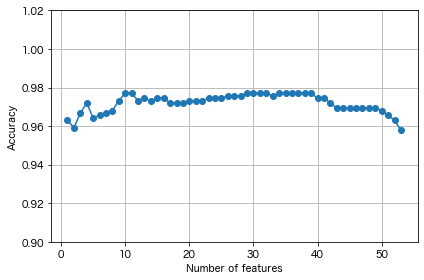

In [34]:
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt

# k近傍法分類期のインスタンスを生成（近傍点数=5）
knn = KNeighborsClassifier(n_neighbors=5)

# 逐次後退選択のインスタンスを生成（特徴量の個数が1になるまで特徴量を選択）
sbs = SBS(knn, k_features=1)
# 逐次後退選択を実行
sbs.fit(X_train_std, y_train)

# 特徴量の個数のリスト（53,52...,1）
k_feat = [len(k) for k in sbs.subsets_]

# 横軸を特徴量の個数、縦軸をスコアとした折れ線グラフのプロット
plt.plot(k_feat, sbs.scores_, marker='o')
plt.ylim([0.9, 1.02])
plt.ylabel('Accuracy')
plt.xlabel('Number of features')
plt.grid()
plt.tight_layout()
plt.show()

In [35]:
# 最小限の特徴部分集合を確認する
k3 = list(sbs.subsets_[50])
print(data_ph.columns[2:][k3])

k5 = list(sbs.subsets_[48])
print(data_ph.columns[2:][k5])

Index(['三塁打', '敬遠', 'XR'], dtype='object')
Index(['身長', '三塁打', '敬遠', '死球', 'XR'], dtype='object')


In [36]:
# 53個すべての特徴量を用いてモデルを適合
knn.fit(X_train_std, y_train)
# トレーニングの正解率を出力
print('Training accuracy:', knn.score(X_train_std, y_train))

# テストの正解率を出力
print('Test accuracy:', knn.score(X_test_std, y_test))

Training accuracy: 0.9747765006385696
Test accuracy: 0.9650037230081906


In [37]:
# 3つの特徴量を用いてモデルを適合
knn.fit(X_train_std[:, k3], y_train)
# トレーニングの正解率を出力
print('Training accuracy:', knn.score(X_train_std[:, k3], y_train))

# テストの正解率を出力
print('Test accuracy:', knn.score(X_test_std[:, k3], y_test))

Training accuracy: 0.972860791826309
Test accuracy: 0.9687267311988086


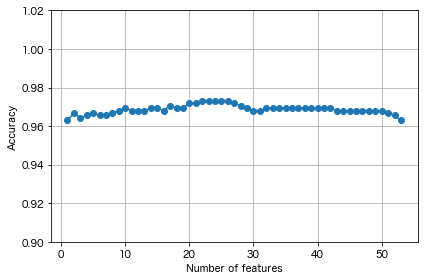

In [40]:
#近傍点数を増やしてみる

from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt

# k近傍法分類期のインスタンスを生成（近傍点数=10）
knn = KNeighborsClassifier(n_neighbors=10)

# 逐次後退選択のインスタンスを生成（特徴量の個数が1になるまで特徴量を選択）
sbs = SBS(knn, k_features=1)
# 逐次後退選択を実行
sbs.fit(X_train_std, y_train)

# 特徴量の個数のリスト（53,52...,1）
k_feat = [len(k) for k in sbs.subsets_]

# 横軸を特徴量の個数、縦軸をスコアとした折れ線グラフのプロット
plt.plot(k_feat, sbs.scores_, marker='o')
plt.ylim([0.9, 1.02])
plt.ylabel('Accuracy')
plt.xlabel('Number of features')
plt.grid()
plt.tight_layout()
# plt.savefig('images/04_08.png', dpi=300)
plt.show()

In [41]:
# 最小限の特徴部分集合を確認する
k3 = list(sbs.subsets_[50])
print(data_ph.columns[2:][k3])

k5 = list(sbs.subsets_[48])
print(data_ph.columns[2:][k5])

Index(['盗塁刺', '四球', '敬遠'], dtype='object')
Index(['三塁打', '盗塁刺', '四球', '敬遠', '死球'], dtype='object')


In [42]:
# 53個すべての特徴量を用いてモデルを適合
knn.fit(X_train_std, y_train)
# トレーニングの正解率を出力
print('Training accuracy:', knn.score(X_train_std, y_train))

# テストの正解率を出力
print('Test accuracy:', knn.score(X_test_std, y_test))

Training accuracy: 0.9677522349936143
Test accuracy: 0.9657483246463142


In [43]:
# 3つの特徴量を用いてモデルを適合
knn.fit(X_train_std[:, k3], y_train)
# トレーニングの正解率を出力
print('Training accuracy:', knn.score(X_train_std[:, k3], y_train))

# テストの正解率を出力
print('Test accuracy:', knn.score(X_test_std[:, k3], y_test))

Training accuracy: 0.9632822477650064
Test accuracy: 0.9635145197319435


# ランダムフォレストで特徴量の重要度にアクセスする

 1) XR                             0.074840
 2) RC                             0.071534
 3) 安打                             0.056224
 4) 塁打                             0.056155
 5) 打点                             0.046062
 6) 打席数                            0.041091
 7) 得点                             0.032455
 8) RC27                           0.031286
 9) 試合                             0.028467
10) 打数                             0.028051
11) 打率                             0.026198
12) XR27                           0.025569
13) OPS                            0.025566
14) 二塁打                            0.024899
15) 本塁打                            0.024005
16) NOI                            0.022442
17) GPA                            0.022289
18) 四球                             0.021474
19) 長打率                            0.020934
20) TA                             0.017629
21) 三振                             0.016481
22) 出塁率                            0.016362
23) 本塁打率                        

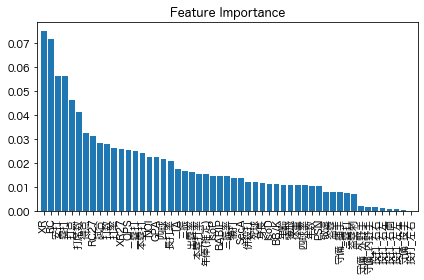

In [38]:
#以下教科書p134-135から引用・改変
# データセットの名称
feat_labels = data_ph.columns[2:]

# ランダムフォレストオブジェクトの生成（決定木の個数=500）
forest = RandomForestClassifier(n_estimators=500, random_state=1)

# モデルを適合
forest.fit(X_train, y_train)
# 特徴量の重要度を抽出
importances = forest.feature_importances_
# 重要度の降順で特徴量のインデックスを抽出
indices = np.argsort(importances)[::-1]

# 重要度の降順で特徴量の名称、重要度を表示
for f in range(X_train.shape[1]):
    print("%2d) %-*s %f" % (f + 1, 30, 
                            feat_labels[indices[f]], 
                            importances[indices[f]]))

plt.title('Feature Importance')
plt.bar(range(X_train.shape[1]), 
        importances[indices],
        align='center')

plt.xticks(range(X_train.shape[1]), 
           feat_labels[indices], rotation=90)
plt.xlim([-1, X_train.shape[1]])
plt.tight_layout()
plt.show()

 1) RC                             0.078509
 2) XR                             0.070406
 3) 安打                             0.057557
 4) 塁打                             0.055098
 5) 打点                             0.045324
 6) 打席数                            0.040915
 7) 得点                             0.034236
 8) RC27                           0.030858
 9) 打数                             0.030285
10) XR27                           0.026938
11) 試合                             0.025783
12) 打率                             0.025479
13) OPS                            0.024304
14) 二塁打                            0.023567
15) NOI                            0.023564
16) GPA                            0.023290
17) 本塁打                            0.020899
18) 四球                             0.020624
19) 長打率                            0.019424
20) TA                             0.018045
21) 三振                             0.016582
22) 年俸(推定)                         0.015561
23) 出塁率                         

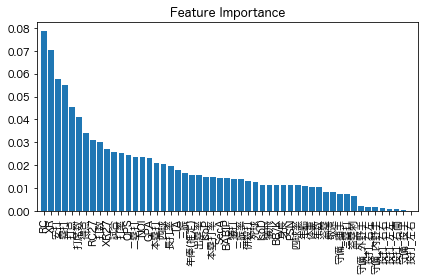

In [44]:
#決定木を2000まで増やしてみる
# データセットの名称
feat_labels = data_ph.columns[2:]

# ランダムフォレストオブジェクトの生成（決定木の個数=2000）
forest = RandomForestClassifier(n_estimators=2000, random_state=1)

# モデルを適合
forest.fit(X_train, y_train)
# 特徴量の重要度を抽出
importances = forest.feature_importances_
# 重要度の降順で特徴量のインデックスを抽出
indices = np.argsort(importances)[::-1]

# 重要度の降順で特徴量の名称、重要度を表示
for f in range(X_train.shape[1]):
    print("%2d) %-*s %f" % (f + 1, 30, 
                            feat_labels[indices[f]], 
                            importances[indices[f]]))

plt.title('Feature Importance')
plt.bar(range(X_train.shape[1]), 
        importances[indices],
        align='center')

plt.xticks(range(X_train.shape[1]), 
           feat_labels[indices], rotation=90)
plt.xlim([-1, X_train.shape[1]])
plt.tight_layout()
plt.show()

# '敬遠', 'XR', 'RC', '安打'から2種類取り出し，分類がうまくいくか確かめる

In [49]:
def plot_decision_regions(X, y, classifier, test_idx=None, resolution=0.02):
    
    #マーカーとカラーマップの準備
    markers = ('s', 'x', 'o', '^', 'v')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])
    
    #決定領域のプロット
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    #グリッドポイントの生成
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution))
    #各特徴量を1次元配列に変換して予測を実行
    Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    #予測結果を元のグリッドポイントのデータサイズに変換
    Z = Z.reshape(xx1.shape)
    #グリッドポイントの等高線のプロット
    plt.contourf(xx1, xx2, Z, alpha=0.3, cmap=cmap)
    #軸の範囲の設定
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())
    
    #クラスごとにサンプルをプロット
    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0], y=X[y == cl, 1],
                    alpha=0.8,
                    c=colors[idx],
                    marker=markers[idx],
                    label=cl,
                    edgecolor='black')
        
    #テストサンプルを目立たせる(点を丸で表示)
    if test_idx:
        #全てのサンプルをプロット
        X_test, y_test = X[test_idx, :], y[test_idx]
        plt.scatter(X_test[:, 0], X_test[:, 1],
                    c='',
                    edgecolor='black',
                    alpha=1.0,
                    linewidth=1,
                    marker='o',
                    s=100,
                    label='test set')

In [79]:
# csvを読み込む
data_ph = pd.read_csv('./output_profile_and_hitting/output_profile_and_hitting.csv')

def plot (left, right):
    # 特徴量とクラスラベルを別々に抽出 12,23,34,36
    X, y = data_ph.iloc[:, [left, right]].values, data_ph.iloc[:, 1].values
    # トレーニングデータとテストデータに分割
    # 全体の30%をテストデータにする
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0, stratify=y)

    sc = StandardScaler()
    #トレーニングデータの平均と標準偏差を計算
    sc.fit(X_train)
    #平均と標準偏差を用いて標準化
    X_train_std = sc.transform(X_train)
    X_test_std = sc.transform(X_test)

    #エポック数40、学習率0.1でパーセプトロンのインスタンスを生成
    ppn = Perceptron(max_iter=40, eta0=0.1, random_state=1)
    #トレーニングデータをモデルに適合させる
    ppn.fit(X_train_std, y_train)

    #テストデータで予測を実施
    y_pred = ppn.predict(X_test_std)
    #誤分類のサンプルの個数を表示
    print('Misclassified samples: %d' % (y_test != y_pred).sum())
    print('Accuracy: %.2f' % accuracy_score(y_test, y_pred))
    print('Accuracy: %.2f' % ppn.score(X_test_std, y_test))

    #トレーニングデータとテストデータの特徴量を行方向に結合
    X_combined_std = np.vstack((X_train_std, X_test_std))
    #トレーニングデータとテストデータのクラスラベルを結合
    y_combined = np.hstack((y_train, y_test))
    #決定境界のプロット
    plot_decision_regions(X=X_combined_std, y=y_combined, classifier=ppn,
                          test_idx=range(105,150))
    #軸のラベルの設定
    plt.xlabel('petal length [standardized]')
    plt.ylabel('petal width [standardized]')
    #凡例の設定(左上に配置)
    plt.legend(loc='upper left')
    #グラフの表示
    plt.tight_layout()
    plt.show()

Misclassified samples: 66
Accuracy: 0.95
Accuracy: 0.95


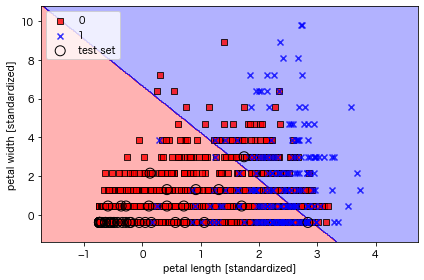

In [81]:
# 安打と敬遠
plot(12, 23)

Misclassified samples: 67
Accuracy: 0.95
Accuracy: 0.95


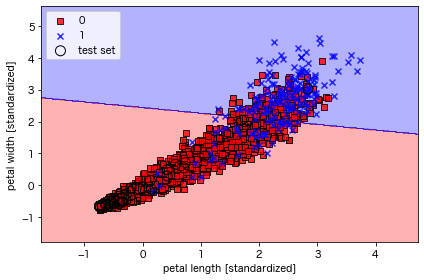

In [82]:
# 安打とRC
plot(12, 34)

Misclassified samples: 40
Accuracy: 0.97
Accuracy: 0.97


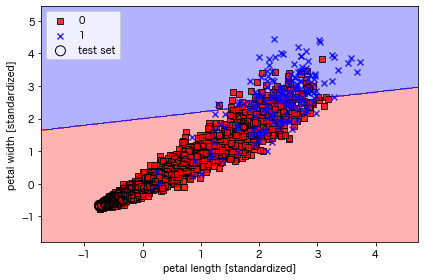

In [83]:
# 安打とXR
plot(12, 36)

Misclassified samples: 61
Accuracy: 0.95
Accuracy: 0.95


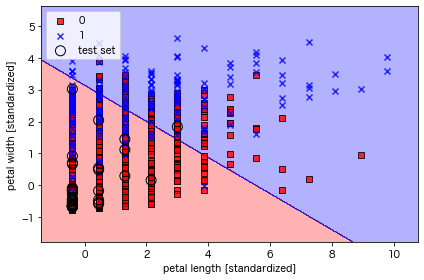

In [84]:
# 敬遠とRC
plot(23, 34)

Misclassified samples: 74
Accuracy: 0.94
Accuracy: 0.94


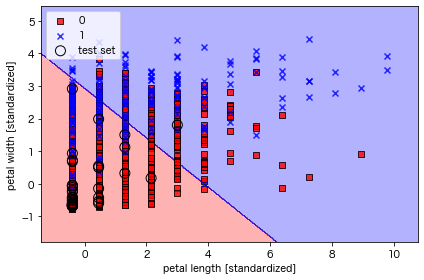

In [85]:
# 敬遠とXR
plot(23, 36)

Misclassified samples: 62
Accuracy: 0.95
Accuracy: 0.95


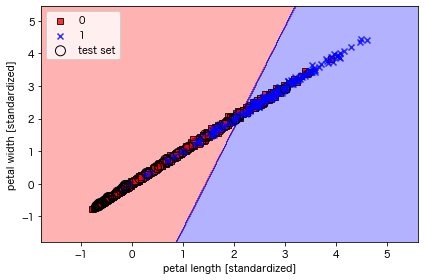

In [86]:
# RCとXR
plot(34, 36)

XRはRCを改良した指標であり，相関が高いためにこのような直線的な結果になったと考えられる．